<a href="https://colab.research.google.com/github/kgpark88/bigdata/blob/main/DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 심층신경망(DNN, Deep Neural Network)

① 라이브러리 임포트(import)  
② 데이터 가져오기(Loading the data)  
③ 탐색적 데이터 분석(Exploratory Data Analysis)  
④ 데이터 전처리(Data PreProcessing) : 데이터타입 변환, Null 데이터 처리, 누락데이터 처리, 
카테고리 데이터, 더미특성 생성, 특성 추출 (feature engineering) 등  
⑤ Train, Test  데이터셋 분할  
⑥ 데이터 정규화(Normalizing the Data)  
⑦ 모델 개발(Creating the Model)  
⑧ 모델 성능 평가

### ① 라이브러리 임포트

In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

### ② 데이터 로드

In [2]:
# from aicentro.session import Session
# from aicentro.framework.keras import Keras as AiduFrm

# aidu_session = Session(verify=False)
# aidu_framework = AiduFrm(session=aidu_session)

# df = pd.read_csv(aidu_framework.config.data_dir + '/churn_data.csv')

In [3]:
# df = pd.read_csv('churn_data.csv')
df = pd.read_csv('https://raw.githubusercontent.com/kgpark88/ai-summary/main/churn_data.csv')

### ③ 데이터 분석

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


<Axes: >

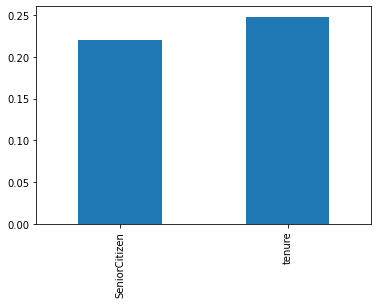

In [7]:
df.corr()['MonthlyCharges'][:-1].sort_values().plot(kind='bar')

### ④ 데이터 전처리

In [8]:
df.drop('customerID', axis=1, inplace=True)

In [9]:
df['TotalCharges'].replace([' '], ['0'], inplace=True)

In [10]:
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [11]:
df['Churn'].replace(['Yes', 'No'], [1, 0], inplace=True)

### 더미 특성 생성

In [12]:
cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
        'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
        'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 
        'PaperlessBilling', 'PaymentMethod']

In [13]:
dummies = pd.get_dummies(df[cols], drop_first=True)

In [14]:
df = df.drop(cols, axis=1)

In [15]:
df = pd.concat([df, dummies], axis=1)

In [16]:
# df = pd.get_dummies(df)
# cols = list(df.select_dtypes('object').columns)

### ⑤ 데이터셋을 Train, , Validation, Test 데이터셋으로 분할

In [53]:
from sklearn.model_selection import train_test_split

In [54]:
X = df.drop('Churn', axis=1).values
y = df['Churn'].values

In [55]:
# 트레이닝셋, 테스트셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify = y)

In [56]:
# 트레이닝셋,  벨리데이션셋으로 분할
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=2023, stratify = y_train)

### 데이터 정규화/스케일링(Normalizing/Scaling)

In [22]:
from sklearn.preprocessing import MinMaxScaler

In [63]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### 모델 입력갯수, 출력갯수 확인

In [64]:
print(X_train.shape, y_train.shape)

(3943, 30) (3943,)


### ⑦ 모델 구성

In [73]:
keras.backend.clear_session()

model = Sequential()
# input layer
model.add(Dense(64, activation='relu', input_shape=(30,)))
# hidden layer
model.add(Dense(64, activation='relu'))
# hidden layer
model.add(Dense(32, activation='relu'))
# output layer
model.add(Dense(1, activation='sigmoid'))

### 모델 구성 -  과적합 방지

In [74]:
keras.backend.clear_session()

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(30,)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

### 모델 확인

In [75]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3968      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

In [76]:
hidden1 = model.layers[0]

In [77]:
weights, biases = hidden1.get_weights()

In [78]:
print(weights)

[[-0.03555073 -0.18603832  0.02515307 ...  0.13012834  0.1022905
   0.10792516]
 [-0.05696166  0.15421043  0.17751233 ... -0.06471987 -0.12503266
   0.16958888]
 [-0.08728001  0.11450626 -0.1785338  ... -0.1090451   0.03406435
   0.05220816]
 ...
 [-0.15225217  0.18105175 -0.00508106 ... -0.08866696  0.00250109
  -0.04038967]
 [ 0.02474625  0.16756539 -0.19039197 ...  0.06915136 -0.1588515
   0.19321676]
 [-0.03241852  0.11690785  0.06343757 ...  0.09970258 -0.01004902
  -0.02281632]]


In [79]:
print(biases)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


#### 모델 컴파일 – 이진 분류 모델

In [80]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy']) 

- 모델 컴파일 – 다중 분류 모델  
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy']) 


- 모델 컴파일 – 예측 모델
model.compile(optimizer='adam', loss='mse')

### 모델 훈련(학습) 하기

In [82]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=20, 
          batch_size=10)

Epoch 1/20
395/395 [==============================] - 2s 5ms/step - loss: 0.4330 - accuracy: 0.7890 - val_loss: 0.4096 - val_accuracy: 0.8084
Epoch 2/20
395/395 [==============================] - 2s 5ms/step - loss: 0.4354 - accuracy: 0.8004 - val_loss: 0.4110 - val_accuracy: 0.8019
Epoch 3/20
395/395 [==============================] - 2s 4ms/step - loss: 0.4392 - accuracy: 0.7994 - val_loss: 0.4092 - val_accuracy: 0.8037
Epoch 4/20
395/395 [==============================] - 2s 5ms/step - loss: 0.4313 - accuracy: 0.8012 - val_loss: 0.4180 - val_accuracy: 0.8019
Epoch 5/20
395/395 [==============================] - 2s 5ms/step - loss: 0.4315 - accuracy: 0.7938 - val_loss: 0.4051 - val_accuracy: 0.7995
Epoch 6/20
395/395 [==============================] - 3s 7ms/step - loss: 0.4277 - accuracy: 0.7986 - val_loss: 0.4122 - val_accuracy: 0.8001
Epoch 7/20
395/395 [==============================] - 3s 7ms/step - loss: 0.4316 - accuracy: 0.7986 - val_loss: 0.4080 - val_accuracy: 0.7907
Epoch 

### 모델 훈련(학습) - 조기종료

In [83]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', 
                           verbose=1, patience=25)

In [84]:
check_point = ModelCheckpoint('best_model.h5', verbose=1,
                              monitor='val_loss', mode='min', 
                              save_best_only=True)

In [85]:
history = model.fit(x=X_train, y=y_train, 
          epochs=50 , batch_size=20,
          validation_data=(X_valid, y_valid), 
          verbose=1,
          callbacks=[early_stop, check_point])

Epoch 1/50
188/198 [===========================>..] - ETA: 0s - loss: 0.4091 - accuracy: 0.8120
Epoch 1: val_loss improved from inf to 0.41280, saving model to best_model.h5
198/198 [==============================] - 1s 7ms/step - loss: 0.4113 - accuracy: 0.8116 - val_loss: 0.4128 - val_accuracy: 0.7954
Epoch 2/50
192/198 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8201
Epoch 2: val_loss improved from 0.41280 to 0.41104, saving model to best_model.h5
198/198 [==============================] - 1s 6ms/step - loss: 0.4057 - accuracy: 0.8199 - val_loss: 0.4110 - val_accuracy: 0.7930
Epoch 3/50
189/198 [===========================>..] - ETA: 0s - loss: 0.3934 - accuracy: 0.8209
Epoch 3: val_loss did not improve from 0.41104
198/198 [==============================] - 1s 5ms/step - loss: 0.3930 - accuracy: 0.8199 - val_loss: 0.4148 - val_accuracy: 0.7936
Epoch 4/50
193/198 [============================>.] - ETA: 0s - loss: 0.4045 - accuracy: 0.8187
Epoch 4: val_los

### ⑧ 모델 성능 평가

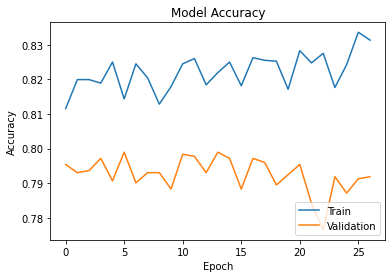

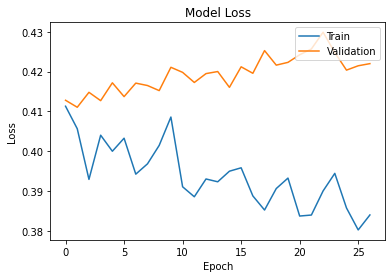

In [86]:
import matplotlib.pyplot as plt

# 모델 정확도(accuracy)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# 모델 손실(loss)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [88]:
def predict_class(y_pred, thresh=0.5):
    return tf.cast(y_pred > thresh, tf.float32)

from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(X_test)
y_pred_class = predict_class(y_pred)
cm = confusion_matrix(y_test, y_pred_class)
print(cm)

print(classification_report(y_test, y_pred_class))

45/45 [==============================] - 0s 4ms/step
[[915 120]
 [155 219]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1035
           1       0.65      0.59      0.61       374

    accuracy                           0.80      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409

